# Drift explanation: Bounding Boxes

In [1]:
# Reload modules every time before executing the Python code typed
%load_ext autoreload
%autoreload 2

# Import from code root directory
import sys; sys.path.insert(0, '../')

# Imports experiment data
from access.interim_storage import InterimStorage
from access.amazon_pickle_splitter import AmazonPickleSplitter
import timeit

# Imports experiment
from explanations.bounding_boxes import BoundingBoxes
from explanations.wordcloud import Wordcloud

# Configuration
directory_pickle = '/home/eml4u/EML4U/data/amazon-complete/'

## Load experiment data

- Years: 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012
- Stars: 1, 5
- Items, each pair year-star: 10,000 texts and related BoW-50 embeddings
- Items, overall: years x stars x items: 13 x 2 x 10,000 = 260,000

In [2]:
# Load prepared data, if available
storage = InterimStorage('amazon_1and5star_2000to2012_10000')
if(storage.isfile()):
    time_begin = timeit.default_timer()
    data = storage.read()
    print('Load duration:', timeit.default_timer() - time_begin)
    # Preparation duration: 91.39764809887856

# Data not available: Prepare data
def extract_data(years, stars, max_items, amazon_pickle_directory):
    splitter = AmazonPickleSplitter(amazon_pickle_directory)
    raw_ids = splitter.get_data_splits(years=years, stars=stars, max_items=max_items)
    data = {}
    for year in years:
        data[year] = {}
        for star in stars:
            data[year][star] = []
            for raw_id in raw_ids[year][star]:
                data[year][star].append((raw_id, splitter.get_text(raw_id), splitter.get_bow50(raw_id)))
    return data
if(not storage.isfile()):
    years     = [year for year in range(2000, 2012+1)] 
    stars     = [0, 4]
    max_items = 10 * 1000
    time_begin = timeit.default_timer()
    data = extract_data(years, stars, max_items, directory_pickle)
    storage.write(data)
    print('Preparation duration:', timeit.default_timer() - time_begin)
    # Load duration: 14.777344818925485

# Indexes of the generated 3-tuples
RAWID = 0
TEXT  = 1
BOW50 = 2
# From configuration
YEARS      = list(data.keys())
STARS      = list(data[YEARS[0]].keys())
ITEMS      = len(data[YEARS[0]][STARS[0]])
DIMENSIONS = len(data[YEARS[0]][STARS[0]][0][BOW50])
# Indexes of stars
STAR1 = 0
STAR5 = 4

Preparation duration: 286.8458598369034


## Data overview / example

In [3]:
def print_tuple(year, star, index):                                                     # TODO access all
    print()
    print('Index:', index)
    print('Raw ID:', data[year][star][index][RAWID])
    print('Text:',   data[year][star][index][TEXT])
    print('BoW 50:', data[year][star][index][BOW50])

In [4]:
print('Years:       ', YEARS, len(YEARS))
print('Stars (+1):  ', STARS)
print('Items (each):', ITEMS)
print('Dimensions:  ', DIMENSIONS)

print_tuple(2000, 0, 0)

Years:        [2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012] 13
Stars (+1):   [0, 4]
Items (each): 10000
Dimensions:   50

Index: 0
Raw ID: 84120
Text: Raiders of the Living Dead In the name of GOD don't buy this movie. The cover art was better than the movie. (I use the term movie loosely) The acting was the worst thing I have ever seen. I have spent more money on a good dinner than was spent on the  special effects for this (movie). I should have turned it off after the kid  turned his Grand Fathers Laser Disk Player in to a death ray. The same  effect used to beam people up in the old Star Trek TV series was used to  make the laser beams. (scraching the film) After watching this (movie) I  could not even bring myself to rewind it. It now sit on the self and I  threaten to tie the kids up and make the watch it again if they act up.
BoW 50: [ 1.1033126   0.27128553  0.42552614 -0.6118531  -0.1449115   0.9803143
 -0.6885979  -0.36055896  0.24956799 -0.10

## Bounding Boxes

In [5]:
# Configuration
percentile = 0.2
# TODO: check other percentile types https://numpy.org/doc/stable/reference/generated/numpy.percentile.html

### Create boxes

In [ ]:
embeddings_dict = {}

BoundingBoxes().execute(0.2, 

In [6]:
def create_boxes(year, star, percentile):
    boxes = BoundingBoxes()
    
    # (1) Collect values of single dimensions/indexes of embeddings
    for tup in data[year][star]:
        boxes.add_embedding(tup[BOW50])

    # (2) Use values of single dimensions to calculate min/max.
    #     Regions can be shrinked by percentiles.
    boxes.update_boundaries(percentile)
    
    return boxes

In [7]:
boxes = {}
for year in YEARS:
    boxes[year] = {}
    for star in STARS:
        boxes[year][star] = create_boxes(year, star, percentile)

### Get embeddings outside boxes

In [8]:
def get_indexes_outside_boxes(box, embedding_tuples):
    indexes = []
    for index, tup in enumerate(embedding_tuples):
        # (3) A counter which is incremented, if an embedding value of another(!) 
        # distribution is inside the previously calculated boundaries.
        if(box.get_number_of_enclosed_dimensions(tup[BOW50]) < DIMENSIONS):    # TODO maybe more dimensions
                            # TODO: Maybe check including only <49 instead of <50 and use other percentiles
            indexes.append(index)
    return indexes

In [9]:
results = {}
for year in YEARS:
    results[year] = {}
    for star in STARS:
        if(star == STAR1):
            opposite_star = STAR5
        else:
            opposite_star = STAR1
        results[year][star] = get_indexes_outside_boxes(boxes[year][star], data[year][opposite_star])

In [10]:
for result in results.items():
    print(result[0], len(result[1][STAR1]), len(result[1][STAR5]))

2000 3437 2650
2001 3090 2900
2002 3309 2236
2003 2735 2831
2004 3071 3075
2005 3108 2592
2006 2999 2575
2007 3089 2814
2008 3203 2820
2009 3003 3337
2010 3339 2921
2011 3062 2894
2012 3213 2992


In [11]:
wordcloud = Wordcloud()
def plot_clouds(year):
    tokens = {}
    for star in results[year].keys():
        texts = []
        for index in results[year][star]:
            texts.append(data[year][star][index][TEXT])
        tokens[star] = wordcloud.get_tokens(texts)

    cloud = wordcloud.get_wordcloud(wordcloud.remove_tokens(tokens[STAR5], tokens[STAR1]))
    wordcloud.plot(cloud)
    cloud = wordcloud.get_wordcloud(wordcloud.remove_tokens(tokens[STAR1], tokens[STAR5]))
    wordcloud.plot(cloud)

In [24]:
                                   # TODO: Use clustering to separate clusters and generate multiple explanations

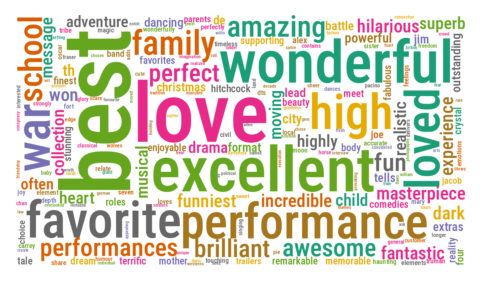

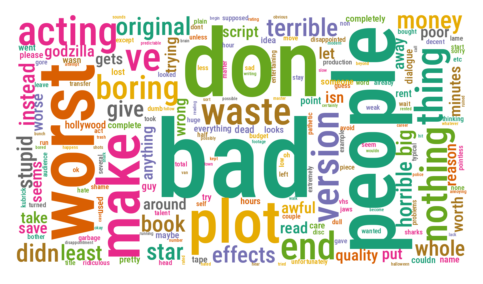

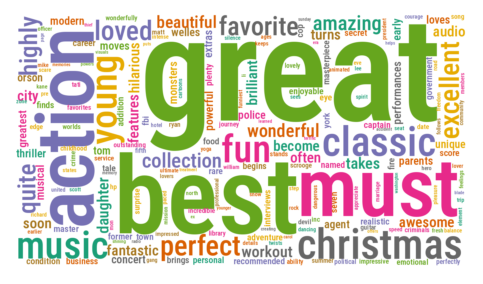

In [ ]:
plot_clouds(2000)
plot_clouds(2010)